# Custom Kernel for latent forces

In [102]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_data import JAXP53_Data, load_barenco_data, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

In [103]:
# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al. (plotted points on GP graph)
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

In [104]:
def flatten_dataset_jax(dataset):
    """
    Flatten the dataset using JAX operations, modified to handle multiple replicates if needed.

    Args:
        dataset: The dataset containing gene data.

    Returns:
        train_t: The flattened time values.
        train_y: The flattened observed values across genes and potentially replicates.
    """
    # Get the total number of entries in the dataset (this will vary if multiple replicates are included)
    num_entries = len(dataset)

    # Extract time points from the first entry; assuming all entries have the same time points
    train_t = dataset[0][0]
    num_times = train_t.shape[0]

    # Collect all observed values, now accounting for all entries in the dataset
    m_observed = jnp.concatenate([dataset[i][1] for i in range(num_entries)])

    # Each entry in `dataset` corresponds to (time, values) for a gene in a replicate
    # Since each gene at each time point is an entry, we need to repeat `train_t` for each entry
    train_t = jnp.tile(train_t, num_entries)

    # `m_observed` is already in the correct shape, directly from concatenation
    train_y = m_observed.reshape(-1)

    return train_t, train_y

In [105]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

p53_data = JAXP53_Data(replicate=2)
train_t , train_y = flatten_dataset_jax(p53_data)

# Set random key
key = jr.PRNGKey(123)

ValueError: too many values to unpack (expected 2)

In [ ]:
p53_test = JAXP53_Data()
train_t2, train_y2 = flatten_dataset_jax(p53_test)

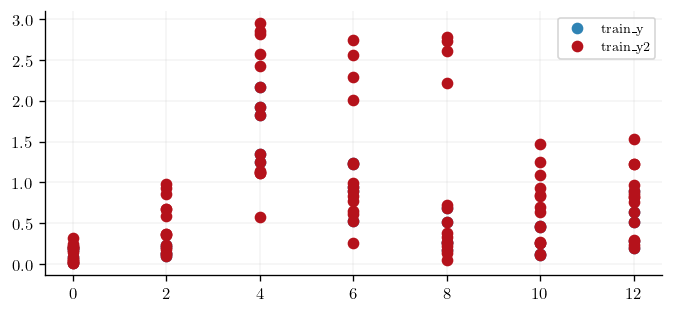

In [ ]:
# plot train_y and train_y2

plt.plot(train_t, train_y, 'o', label='train_y')
plt.plot(train_t2, train_y2, 'o', label='train_y2')
plt.legend()
plt.show()

In [ ]:
m_observed, f_observed, gene_var, tf_var, t = load_barenco_data(data_dir)

In [ ]:
m_observed[1].shape

(3, 5, 7)

In [ ]:
# TODO: move this to data class itself (?)

num_genes = p53_data.num_outputs
# (num_genes, dimension, num_timepoints)
gene_data = jnp.array([p53_data[i] for i in range(num_genes)])

time_points = gene_data[0,0,:]
time_points_repeated = jnp.tile(time_points, gene_data.shape[0])
gene_indices = jnp.repeat(jnp.arange(gene_data.shape[0]), len(time_points))
print(gene_indices)

# Shape (t x j) x 3 where t is timepoints and j is genes
training_times = jnp.stack((time_points_repeated, gene_indices, jnp.ones(num_genes * len(time_points), dtype=int)), axis=-1)


# Shape (t x j) x 1 where t is timepoints and j is genes
gene_expressions = gene_data[:,1,:].flatten().reshape(-1,1)

dataset_train = gpx.Dataset(training_times, gene_expressions)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4]


In [ ]:
gene_expressions

Array([[0.17238177],
       [0.23264388],
       [1.92464882],
       [1.22534649],
       [0.68403809],
       [0.46037239],
       [0.89290156],
       [0.19510971],
       [0.09759664],
       [2.16464784],
       [0.89689396],
       [0.26302294],
       [0.11858324],
       [0.28305556],
       [0.08857048],
       [0.14190979],
       [1.35116539],
       [0.94570607],
       [0.27215756],
       [0.2544362 ],
       [0.51773185],
       [0.01876506],
       [0.12216444],
       [1.24857003],
       [0.53118723],
       [0.16929122],
       [0.11145665],
       [0.19135888],
       [0.20769934],
       [0.21061597],
       [1.82892805],
       [1.24125571],
       [0.5166152 ],
       [0.46197937],
       [0.64339332]], dtype=float64)

In [ ]:
training_times[:,0].reshape(-1,1)

Array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 2.],
       [ 4.],
       [ 4.],
       [ 4.],
       [ 4.],
       [ 4.],
       [ 6.],
       [ 6.],
       [ 6.],
       [ 6.],
       [ 6.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [12.],
       [12.],
       [12.],
       [12.],
       [12.]], dtype=float64)

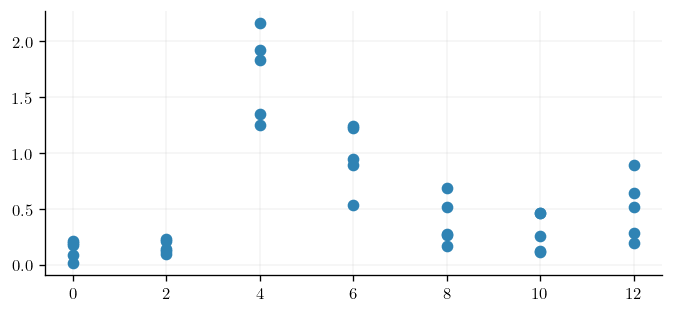

In [ ]:
plt.plot(training_times[:,0],gene_expressions, 'o')
plt.show()

In [108]:
# Generate test points (t, i, 1):

def gen_test_times(t=100):
    """
    Generate testing times for the model of shape (N, 3) where N is the number of testing times. Default is N = 100
    """
    times = jnp.linspace(0, 12, t)
    # Gene indices shouldn't matter
    gene_indices = jnp.repeat(-1, t)
    testing_times = jnp.stack((times, gene_indices, jnp.repeat(0,t)), axis=-1)
    return testing_times

gen_test_times().shape

(100, 3)

In [109]:
testing_times = gen_test_times()

train_row = dataset_train.X[20]
test_row = testing_times[20]

In [111]:
testing_times

Array([[ 0.        , -1.        ,  0.        ],
       [ 0.12121212, -1.        ,  0.        ],
       [ 0.24242424, -1.        ,  0.        ],
       [ 0.36363636, -1.        ,  0.        ],
       [ 0.48484848, -1.        ,  0.        ],
       [ 0.60606061, -1.        ,  0.        ],
       [ 0.72727273, -1.        ,  0.        ],
       [ 0.84848485, -1.        ,  0.        ],
       [ 0.96969697, -1.        ,  0.        ],
       [ 1.09090909, -1.        ,  0.        ],
       [ 1.21212121, -1.        ,  0.        ],
       [ 1.33333333, -1.        ,  0.        ],
       [ 1.45454545, -1.        ,  0.        ],
       [ 1.57575758, -1.        ,  0.        ],
       [ 1.6969697 , -1.        ,  0.        ],
       [ 1.81818182, -1.        ,  0.        ],
       [ 1.93939394, -1.        ,  0.        ],
       [ 2.06060606, -1.        ,  0.        ],
       [ 2.18181818, -1.        ,  0.        ],
       [ 2.3030303 , -1.        ,  0.        ],
       [ 2.42424242, -1.        ,  0.   

In [93]:
@dataclass
class p53_kxx(gpx.kernels.AbstractKernel):
    r"Covariance function of gene expressions j and k at time t and t'"

    name: str = 'kxx'

    """
    # TODO: review inverse initialisation method - check if init as list or single param
    pos_constraint: Callable = tfb.Softplus()
    initial_s: Float[Array, " O"] = static_field(pos_constraint.inverse(1.0))
    initial_d: Float[Array, " O"] = static_field(pos_constraint.inverse(0.4))
    
    # Use dummy variables before trying inverse method
    initial_s_test: Float[Array, " O"] = static_field(jnp.array([1.0]))
    initial_d_test: Float[Array, " O"] = static_field(jnp.array([1.0]))

    # Define sensitivities for both genes
    s_j: Float[Array, " O"] = param_field(initial_s_test, bijector=pos_constraint)
    s_k: Float[Array, " O"] = param_field(initial_s_test, bijector=pos_constraint)

    # Define decay rates for both genes
    d_j: Float[Array, " O"] = param_field(initial_d_test, bijector=pos_constraint)
    d_k: Float[Array, " O"] = param_field(initial_d_test, bijector=pos_constraint)

    # Use measured sensiivities and decays at first
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680]))
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573]))
    """
    true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))

    # Use dummy lengthscale at first
    l: Float[Array, " O"] = static_field(jnp.array([2.5]))
    
    
    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        """
        # Error trap (JAX friendly)
        def check_validity(condition):
            if condition:
                #raise ValueError("t or t' cannot be testing points (z=0)")
                return 0

        condition = jnp.logical_or(t[2] == 0, t_prime[2] == 0)
        jax.debug.callback(check_validity, condition)
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        """
        print('kxx has been called')
        print(self.true_s)
        print(self.true_d)
        print(t.shape)
        print(t_prime.shape)

        print(f'lengthscale {self.l}, {type(self.l)}')
        """

        # NOTE: using index yields same results
        t = self.slice_input(t)
        t_prime = self.slice_input(t_prime)


        """
        print('Inputs have been sliced')
        print(t, t.shape)
        print(t, t_prime.shape)
        """

        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k,j, t_prime, t) + self.h(j,k, t, t_prime)
        

        kxx = mult * second_term

        """
        print(second_term.shape)
        print(f'mult {mult}, shape: {mult.shape}')
        print(f'second term {second_term}, shape: {second_term.shape}')

        print(f'kxx shape {kxx.shape}')
        

        print(f'j index {j}, k index {k}')
        print(f'time 1 {t}, time 2 {t_prime}')
        print(f'sj {self.true_s[j]}, sk {self.true_s[k]}, dj {self.true_d[j]}, dk {self.true_d[k]}')
        """

        return kxx.squeeze()
        
    
    def h(self,j: Int[Array, " O"],k: Int[Array, " O"],t1: Int[Array, " O"],t2: Int[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        t_dist = t2-t1

        multiplier = jnp.exp(self.gamma(k)**2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k]*t_dist)
        first_erf_terms = jax.scipy.special.erf((t_dist / self.l) - self.gamma(k)) + jax.scipy.special.erf(t1/self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k]*t2 + self.true_d[j]*t1))
        second_erf_terms = jax.scipy.special.erf((t2 / self.l) - self.gamma(k)) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (jnp.multiply(first_multiplier, first_erf_terms) - jnp.multiply(second_multiplier, second_erf_terms))

        return result
    
    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) /2


In [94]:
@dataclass
class p53_kxf(gpx.kernels.AbstractKernel):
    r"Cross-covariance between gene expression j at time t and f at time t'"

    name: str = 'cross covariance'

    # TODO: look at initialisation methods and sharing of parameters between covariances

    # Use measured sensiivities and decays at first
    true_s: Float[Array, "1 5"] = static_field(jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680]))
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573]))

    true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))

    # Use dummy lengthscale at first
    l: Float[Array, " O"] = static_field(jnp.array([2.5]))

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:

        """
        # Error trap (JAX friendly)
        def check_val_test(condition):
            if condition:
                #raise ValueError("t and t' cannot both be testing points (z=0)")
                return 0
            
        def check_val_train(condition):
            if condition:
                raise ValueError("t and t' cannot both be training points (z=1)")
                
            
        cond_test = jnp.logical_and(t[2] == 0, t_prime[2] == 0)
        cond_train = jnp.logical_and(t[2] == 1, t_prime[2] == 1)

        jax.debug.callback(check_val_test, cond_test)
        jax.debug.callback(check_val_train, cond_train)
        """
        
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)
    
        j = gene_xpr[1].astype(int)

        #print(f'Latent force {latent_force}')
        #print(f'Gene expression {gene_xpr}') 

        # Slice inputs
        gene_xpr = self.slice_input(gene_xpr)
        latent_force = self.slice_input(latent_force)

        #print(f'Latent force {latent_force}')
        #print(f'Gene expression {gene_xpr}')

        t_dist = jnp.abs(gene_xpr - latent_force)   
        
        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j)**2)
        second_expon_term = jnp.exp(-self.true_d[j]*t_dist)
        erf_terms = jax.scipy.special.erf((t_dist / self.l) - self.gamma(j)) + jax.scipy.special.erf(latent_force/self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        """
        print(f'first_term {first_term}')
        print(f'first_expon_term {first_expon_term}')
        print(f'second_expon_term {second_expon_term}')
        print(f'erf_terms {erf_terms}')
        """
        
        return kxf.squeeze()
    
    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) /2


In [95]:
@dataclass
class p53_combined_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = 'p53 Cov'

    # Define external kernels
    kernel_xx: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kxx(active_dims=[0]))

    kernel_xf: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kxf(active_dims=[0]))

    kernel_ff: gpx.kernels.AbstractKernel = field(default_factory=lambda: gpx.kernels.RBF(active_dims=[0]))
    

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:

        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        """
        print(f'kxx: {kxx_switch}, kxx {self.kernel_xx(t, t_prime)}')
        print(f'kff: {kff_switch}, kff {self.kernel_ff(t, t_prime)}')
        print(f'kxf: {kxf_switch}, kxf {self.kernel_xf(t, t_prime)}')
        print(f'kfx: {kxf_t_switch}, kxf_t {self.kernel_xf(t_prime, t)}')
        """

        final_kernel = kxx_switch * self.kernel_xx(t, t_prime) + kff_switch * self.kernel_ff(t, t_prime) + kxf_switch * self.kernel_xf(t, t_prime) + kxf_t_switch * self.kernel_xf(t_prime, t)

        return final_kernel
    
    

In [96]:
p53_ker = p53_combined_kernel()
p53_ker(train_row,test_row)

Array(0.59569427, dtype=float64)

In [97]:
meanf = gpx.mean_functions.Zero()
p53_ker = p53_combined_kernel()
prior = gpx.gps.Prior(p53_ker, meanf)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=dataset_train.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64))
posterior = prior * likelihood

In [98]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=dataset_train)

Array(3116263.80259365, dtype=float64)

In [99]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=dataset_train,
)

Optimization terminated successfully.
         Current function value: 40.801278
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23


In [100]:
testing_times.shape

(100, 3)

In [101]:
latent_dist = opt_posterior.predict(testing_times, train_data=dataset_train)

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [102]:
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()

In [122]:
# Plot results
predictive_mean.shape

(100,)

In [129]:
# Count NaNs in predivtive_mean
jnp.isnan(predictive_std).sum()

Array(100, dtype=int64)

In [113]:
testing_times.shape

(100, 3)

In [127]:
type(predictive_dist)

tensorflow_probability.substrates.jax.distributions.mvn_full_covariance.MultivariateNormalFullCovariance

In [123]:
def plot_gp(x_test, predictive_dist):
    """
    Plot LF GP given test points and prediction

    Parameters
    ----------
    x_test: array of shape (n, 3)
    predictive_dist:  jax mvn
    """

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    # (100,)
    x_test = x_test[:,0]

    import matplotlib as mpl
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    
    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")

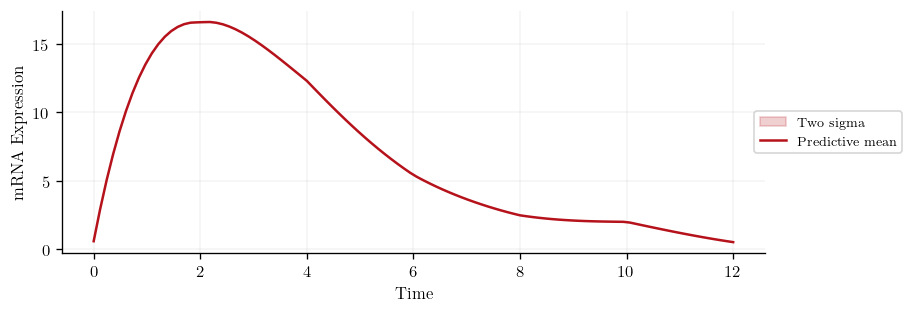

In [126]:
plot_gp(testing_times, predictive_dist)

In [ ]:
import matplotlib as mpl
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(X, Y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    x_test.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)

ax.plot(
    list(range(0,13,2)), f_observed, "x", label="Experimental values", color='red',
)

ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
ax.set_xlabel("Time")
ax.set_ylabel("mRNA Expression")
ax = clean_legend(ax)

In [640]:
k_xf = p53_kxf(active_dims=[0])
k_xf(dataset_train.X[20],test_row)

first_term [2.21556731]
first_expon_term [1.28402542]
second_expon_term [0.10749585]
erf_terms [1.94792912]


Array(0.59569427, dtype=float64)

In [641]:
train_row

Array([8., 2., 1.], dtype=float64)

In [642]:
kxx_ker = p53_kxx(active_dims=[0])
t1 = dataset_train.X
t1.shape

(35, 3)

In [643]:
arr_12 = jnp.array([12, 4, 1])
arr_12t = jnp.array([12, 4, 0])

In [644]:
kxx_ker(arr_12,arr_12)

Array(3.40952609, dtype=float64)

In [645]:
kxf_ker = p53_kxf(active_dims=[0])
kxf_ker(arr_12t,arr_12)

first_term [2.21556731]
first_expon_term [1.28402542]
second_expon_term [1.]
erf_terms [0.47950012]


Array(1.3641034, dtype=float64)

In [650]:
kxf_ker(arr_12t,arr_12)

first_term [2.21556731]
first_expon_term [1.28402542]
second_expon_term [1.]
erf_terms [0.47950012]


Array(1.3641034, dtype=float64)

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


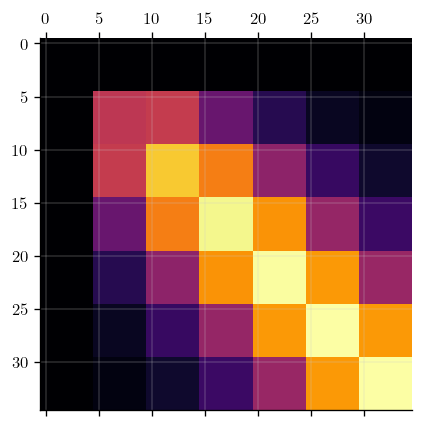

In [586]:
plt.matshow(kxx_ker.gram(t1).to_dense())
plt.show()

(35, 3)

In [ ]:
# HOW TO PLOT KERNEL AND CHECK IT LOOKS OK?

In [344]:
n = 100
noise = 0.3
x_gpr = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f_gpr = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)

kernel_gpr = gpx.kernels.RBF(active_dims=[0])

In [341]:
x_gpr_new = jnp.stack((x_gpr.reshape(-1,), jnp.repeat(0, 100)), axis=-1)
x_gpr_new



Array([[-0.15513296,  0.        ],
       [ 0.20999486,  0.        ],
       [ 2.70871393,  0.        ],
       [-0.24233199,  0.        ],
       [ 0.62798972,  0.        ],
       [-1.04605396,  0.        ],
       [-0.29715902,  0.        ],
       [ 0.89566759,  0.        ],
       [-2.13326535,  0.        ],
       [-1.59715151,  0.        ],
       [ 0.02428609,  0.        ],
       [ 1.92848615,  0.        ],
       [ 1.6970173 ,  0.        ],
       [-0.6035951 ,  0.        ],
       [ 0.26813325,  0.        ],
       [-0.25503812,  0.        ],
       [ 2.57459184,  0.        ],
       [-0.99307462,  0.        ],
       [ 2.10230002,  0.        ],
       [-1.58137953,  0.        ],
       [ 1.57460624,  0.        ],
       [ 0.12240851,  0.        ],
       [-0.70544628,  0.        ],
       [-1.86591987,  0.        ],
       [-1.53468077,  0.        ],
       [ 2.15706123,  0.        ],
       [-1.70874549,  0.        ],
       [-2.28593996,  0.        ],
       [-0.66266154,

## Fixing kernel params

In [116]:
@dataclass
class RBF(AbstractKernel):
    r"""The Radial Basis Function (RBF) kernel."""

    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )
    variance: ScalarFloat = param_field(jnp.array(1.2), bijector=tfb.Softplus())
    name: str = "RBF"

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:

        x = self.slice_input(x) / self.lengthscale
        y = self.slice_input(y) / self.lengthscale
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))
        return K.squeeze()
    
kernel = RBF()

In [120]:
from gpjax.base import meta_leaves

meta_leaves(kernel)

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(1., dtype=float64, weak_type=True)),
 ({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(1.2, dtype=float64, weak_type=True))]

In [117]:
print(jax.tree_util.tree_flatten(kernel))

([Array(1., dtype=float64, weak_type=True), Array(1.2, dtype=float64, weak_type=True)], PyTreeDef(CustomNode(RBF[(['lengthscale', 'variance'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *])))
